In [1]:
import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from utils import load_train_data

pd.set_option('display.max_columns', None)

In [2]:
# Load data
train_data = load_train_data(local=True)
train_data.shape

(260601, 39)

In [3]:
train_data.dtypes

geo_level_1_id                             int64
geo_level_2_id                             int64
geo_level_3_id                             int64
count_floors_pre_eq                        int64
age                                        int64
area_percentage                            int64
height_percentage                          int64
land_surface_condition                    object
foundation_type                           object
roof_type                                 object
ground_floor_type                         object
other_floor_type                          object
position                                  object
plan_configuration                        object
has_superstructure_adobe_mud               int64
has_superstructure_mud_mortar_stone        int64
has_superstructure_stone_flag              int64
has_superstructure_cement_mortar_stone     int64
has_superstructure_mud_mortar_brick        int64
has_superstructure_cement_mortar_brick     int64
has_superstructure_t

## Target
We're trying to predict the ordinal variable `damage_grade`, which represents a level of damage to the building that was hit by the earthquake. There are 3 grades of the damage:
- 1 represents low damage
- 2 represents a medium amount of damage
- 3 represents almost complete destruction

<Axes: ylabel='Frequency'>

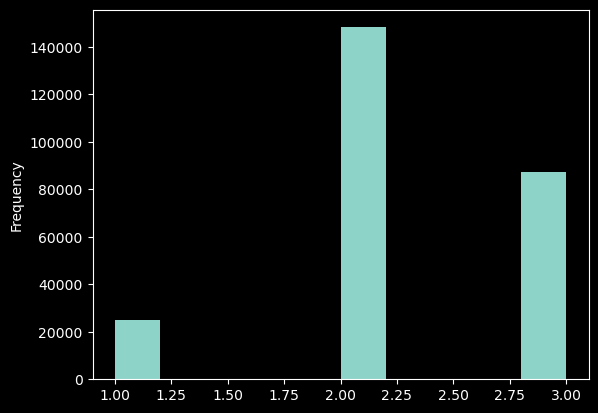

In [4]:
damage = train_data['damage_grade']
damage.plot(kind='hist')

## Numerical data
- `count_floors_pre_eq` (type: int): number of floors in the building before the earthquake

- `age` (type: int): age of the building in years

- `area_percentage` (type: int): normalized area of the building footprint

- `height_percentage` (type: int): normalized height of the building footprint

- `count_families` (type: int): number of families that live in the building.


In [5]:
cols_numerical = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']
num_data = train_data[cols_numerical]
num_data.head()

,count_floors_pre_eq,age,area_percentage,height_percentage,count_families
building_id,,,,,
802906,2,30,6,5,1
28830,2,10,8,7,1
94947,2,10,5,5,1
590882,2,10,6,5,1
201944,3,30,8,9,1


In [6]:
num_data.describe()

,count_floors_pre_eq,age,area_percentage,height_percentage,count_families
count,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000
mean,2.129723,26.535029,8.018051,5.434365,0.983949
std,0.727665,73.565937,4.392231,1.918418,0.418389
min,1.000000,0.000000,1.000000,2.000000,0.000000
25%,2.000000,10.000000,5.000000,4.000000,1.000000
50%,2.000000,15.000000,7.000000,5.000000,1.000000
75%,2.000000,30.000000,9.000000,6.000000,1.000000
max,9.000000,995.000000,100.000000,32.000000,9.000000


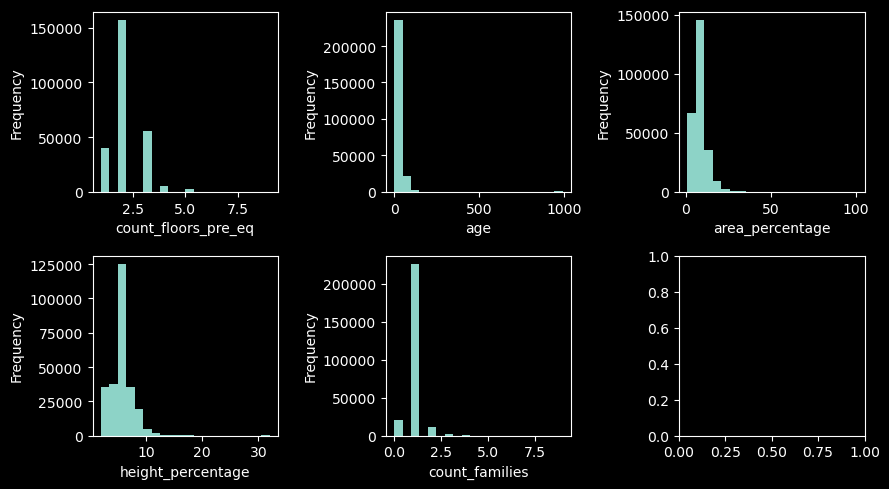

In [7]:
# Plot the distribution of building characteristics
fig, axs = plt.subplots(2, 3, figsize=(9, 5), tight_layout=True)

for i, col in enumerate(cols_numerical):
    num_data[col].plot(kind='hist', bins=20, ax=axs.flatten()[i], xlabel=col)

In [8]:
# pd.cut(x=num_data['count_floors_pre_eq'], bins=[0, 1, 2, 3, 4, 8])
count_floors = num_data['count_floors_pre_eq']
count_floors.value_counts(normalize=True, ascending=False).cumsum()

count_floors_pre_eq
2    0.601007
3    0.814425
1    0.969609
4    0.990422
5    0.999041
6    0.999843
7    0.999992
8    0.999996
9    1.000000
Name: proportion, dtype: float64

<Axes: title={'center': 'Distribution of log area percentage'}, ylabel='Frequency'>

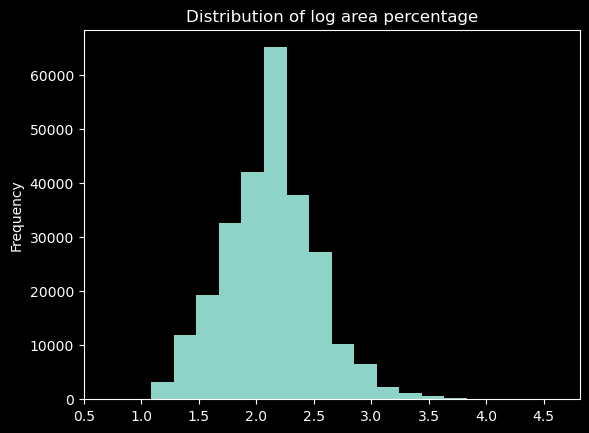

In [9]:
np.log1p(train_data['area_percentage']).plot(kind='hist', bins=20,
                                             title="Distribution of log area percentage")

<Axes: title={'center': 'Distribution of log height percentage'}, ylabel='Frequency'>

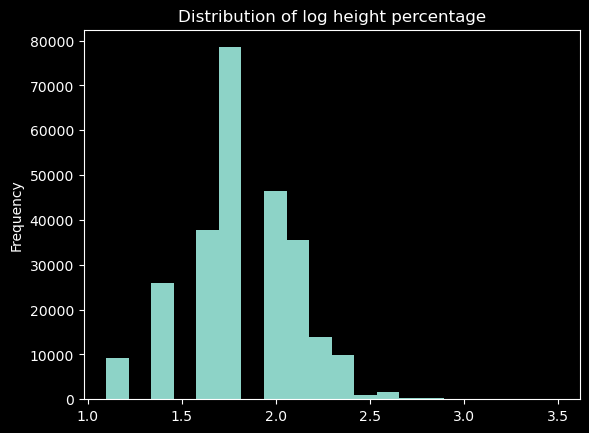

In [10]:
np.log1p(train_data['height_percentage']).plot(kind='hist', bins=20,
                                     title="Distribution of log height percentage")

<Axes: ylabel='Frequency'>

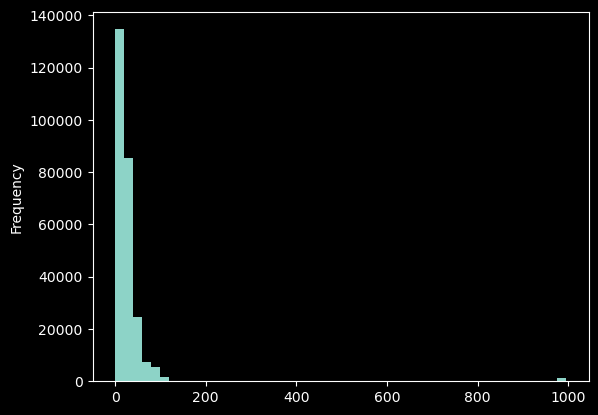

In [11]:
train_data['age'].plot(kind='hist', bins=50)

In [12]:
np.sort(train_data['age'].unique())  #.sort_values(ascending=False)

array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
       130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190,
       195, 200, 995])

<Axes: title={'center': 'Distribution of building age (excluding missing values)'}, ylabel='Frequency'>

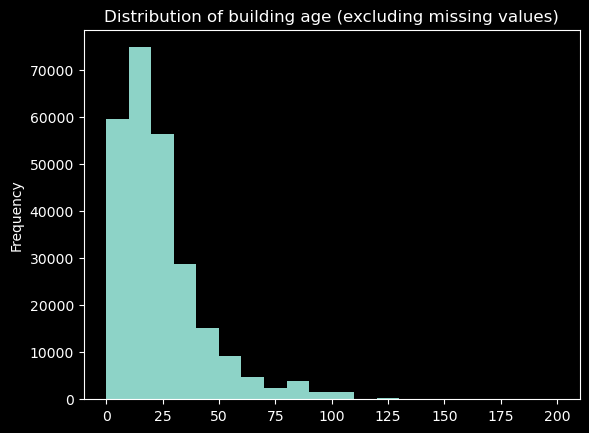

In [13]:
building_age = train_data['age']
building_older_200 = building_age.loc[building_age > 200]

train_data.loc[building_age <= 200, 'age'].plot(kind='hist', bins=20,
                                                title="Distribution of building age (excluding missing values)")

In [14]:
building_age.loc[building_age != 995]

building_id
802906    30
28830     10
94947     10
590882    10
201944    30
          ..
688636    55
669485     0
602512    55
151409    10
747594    10
Name: age, Length: 259211, dtype: int64

## Binary: 'superstructure'

In [19]:
cols_dummy_superstructure = ['has_superstructure_adobe_mud',
                             'has_superstructure_mud_mortar_stone', 
                             'has_superstructure_stone_flag',
                             'has_superstructure_cement_mortar_stone',
                             'has_superstructure_mud_mortar_brick',
                             'has_superstructure_cement_mortar_brick', 
                             'has_superstructure_timber',
                             'has_superstructure_bamboo', 
                             'has_superstructure_rc_non_engineered',
                             'has_superstructure_rc_engineered',
                             'has_superstructure_other']

structure_data = train_data[cols_dummy_superstructure].copy()
structure_data.head()

,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other
building_id,,,,,,,,,,,
802906,1,1,0,0,0,0,0,0,0,0,0
28830,0,1,0,0,0,0,0,0,0,0,0
94947,0,1,0,0,0,0,0,0,0,0,0
590882,0,1,0,0,0,0,1,1,0,0,0
201944,1,0,0,0,0,0,0,0,0,0,0


In [22]:
structure_data.shape

(260601, 11)

In [32]:
# Where damage is low (=1)
structure_damage = structure_data.loc[damage == 3]
for col in structure_damage.columns:
    print(structure_damage[col].value_counts(normalize=True).sort_index())
    
#1: has_superstructure_mud_mortar_stone, has_superstructure_cement_mortar_brick, has_superstructure_timber
#2: has_superstructure_mud_mortar_stone, has_superstructure_timber
#3: has_superstructure_mud_mortar_stone

has_superstructure_adobe_mud
0    0.901339
1    0.098661
Name: proportion, dtype: float64
has_superstructure_mud_mortar_stone
0    0.130294
1    0.869706
Name: proportion, dtype: float64
has_superstructure_stone_flag
0    0.951489
1    0.048511
Name: proportion, dtype: float64
has_superstructure_cement_mortar_stone
0    0.992261
1    0.007739
Name: proportion, dtype: float64
has_superstructure_mud_mortar_brick
0    0.937628
1    0.062372
Name: proportion, dtype: float64
has_superstructure_cement_mortar_brick
0    0.987514
1    0.012486
Name: proportion, dtype: float64
has_superstructure_timber
0    0.7865
1    0.2135
Name: proportion, dtype: float64
has_superstructure_bamboo
0    0.939072
1    0.060928
Name: proportion, dtype: float64
has_superstructure_rc_non_engineered
0    0.983834
1    0.016166
Name: proportion, dtype: float64
has_superstructure_rc_engineered
0    0.99914
1    0.00086
Name: proportion, dtype: float64
has_superstructure_other
0    0.988523
1    0.011477
Name: propor